In [6]:
# !pip install tidy3d  # first install tidy3D first
import tidy3d.web as web
web.configure("gdhAbgn1W9J0TvVFmhK0kVc63WVZvN11cFzHcagypmLA6d4I")

Configured successfully.


In [7]:
import tidy3d.web as web # if needed
web.test()

12:44:27 EEST Authentication configured successfully!

In [8]:
# import packages and authenticate (if needed)
import numpy as np
import matplotlib.pylab as plt
import h5py

import tidy3d as td
import tidy3d.web as web
# web.configure("YOUR API KEY GOES HERE")

# 1. Simulation Setup

First, we define the shape of DOE with diameter $D=80$ $mm$. The relative dielectric permittivity of DOE's material is $\epsilon_r=2.66+j0.03$ at 300 $GHz$.

In [68]:
# the length unit in Tidy3D is micron (um), but we want to simulate the mmWave range.
# this structure is scalable to the wavelength
mm = 1
lda0 = 1
D = 80 * mm
epsilon_r = 2.66
h_substrate = 2 * mm

# 2. Define the Structures and materials

In [69]:
# define the mediums
air = td.Medium(permittivity=1)
resin = td.Medium(permittivity=2.66, name='high-temp resin')

# 2.1 define the doe structure

In [113]:
read_from_csv = True # two method to import model, use .csv file which consist of x-y-z coordinate, or use .stl file (second method is not useable right now!!)

In [152]:
doe_group = []
if not read_from_stl:
    # read doe coordinates data from .csv file
    data = np.loadtxt("diffractive_beam_splitter.csv", delimiter=",")
    X = data[:, 0] * mm
    Y = data[:, 1] * mm
    Z = data[:, 2] * 1e3
    N = int(np.sqrt(X.shape[0]))
    height_map = Z.reshape(N, N)
    dxy = 1 * mm

    #substrate = td.Box(center=[0, 0, -h_substrate/2], size=[D, D, h_substrate])  # add substrate first
    #doe_group.append(substrate)
    for x in range(N):
        for y in range(N):
            # Calculate the center of the current unit and start from the top-left point which x-y cooridnate is (-0.5 * W, 0.5 * L)
            centerX = (-0.5 * N) + (x * dxy) + (dxy / 2)
            centerY = (0.5 * N) - (y * dxy) - (dxy / 2)
            thickness = height_map[y, x] + h_substrate
            centerZ = thickness / 2
            
            center = [centerX, centerY, -centerZ]
            size = [dxy, dxy, thickness]
            doe_unit = td.Box(center=center, size=size)
            doe_group.append(doe_unit)

    doe_structure = td.Structure(
                  geometry=td.GeometryGroup(geometries=doe_group),
                  medium=resin,
                )

<Axes: title={'center': 'cross section at y=40.00'}, xlabel='x', ylabel='z'>

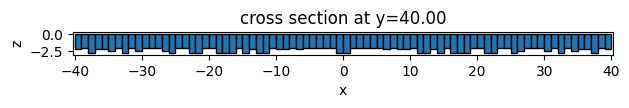

In [153]:
doe_structure.plot(y=40)

# 3. Set up Source and FieldMonitors

In [195]:
freq0 = td.C_0/lda0  # central frequency of the source
fwidth = freq0/10  # frequency width of the source
run_time = 2 / fwidth

# define a plane wave source
source_z = 0.1  #z position of the source
pulse = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
source = td.PlaneWave(size=(td.inf,td.inf,0), center=(0,0,source_z), source_time=pulse, direction='-')

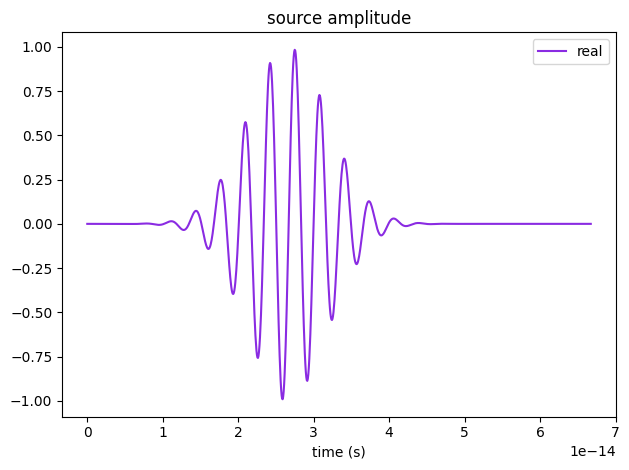

In [196]:
# Visualize source
source.source_time.plot(np.linspace(0, run_time, 1001))
plt.show()

In [197]:
# define a field monitor in the yz plane
field_monitor_yz = td.FieldMonitor(
    center=(0, 0, 0),
    size=(0, td.inf, td.inf),
    freqs=[freq0],
    name="field_yz"
)

# define a field monitor in the xz plane
field_monitor_xz = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq0],
    name="field_xz"
)

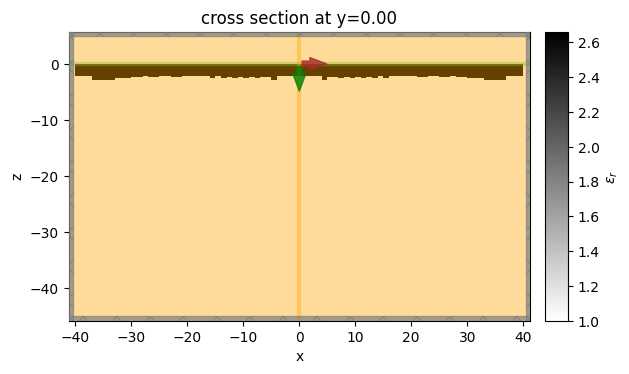

In [198]:
# define simulation domain size
buffer_xy = 1
Lz = 50
sim_size = (D+buffer_xy, D+buffer_xy, Lz)

# define simulation run time
run_time = 1e-12

# define simulation
offset_z = 5
sim = td.Simulation(
    center=(0,0,-Lz/2+offset_z),
    size=sim_size,
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=15),
    sources=[source],
    monitors=[field_monitor_yz, field_monitor_xz],
    structures=[doe_structure],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
    )

sim.plot_eps(y=0)
plt.show()

In [199]:
sim.plot_3d()

In [200]:
job = web.Job(simulation=sim, task_name="beam_splitter")
estimated_cost = web.estimate_cost(job.task_id)

14:37:52 EEST Created task 'beam_splitter' with task_id                         
              'fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=589607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=761261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\taskId]8;;\]8;id=589607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\=]8;;\]8;id=211618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\fdve]8;;\]8;id=589607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\-e67b57e0-0d]8;;\
              ]8;id=589607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\44-4a07-b791-3c914b5d8166']8;;\.

Output()

14:37:56 EEST Maximum FlexCredit cost: 11.560. Minimum cost depends on task     
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

In [201]:
sim_data = job.run(path="data/simulation_data.hdf5")

14:37:57 EEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

14:39:01 EEST status = preprocess

14:39:12 EEST Maximum FlexCredit cost: 11.560. Use 'web.real_cost(task_id)' to  
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

14:43:48 EEST status = postprocess

Output()

14:43:53 EEST status = success

14:43:54 EEST View simulation result at                                         
              ]8;id=48515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=550789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\taskId]8;;\]8;id=48515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\=]8;;\]8;id=391540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\fdve]8;;\]8;id=48515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\-e67b57e0-0d]8;;\
              ]8;id=48515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67b57e0-0d44-4a07-b791-3c914b5d8166\44-4a07-b791-3c914b5d8166']8;;\.

Output()

14:43:58 EEST loading simulation from data/simulation_data.hdf5

14:43:59 EEST WARNING: Simulation final field decay value of 0.000459 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

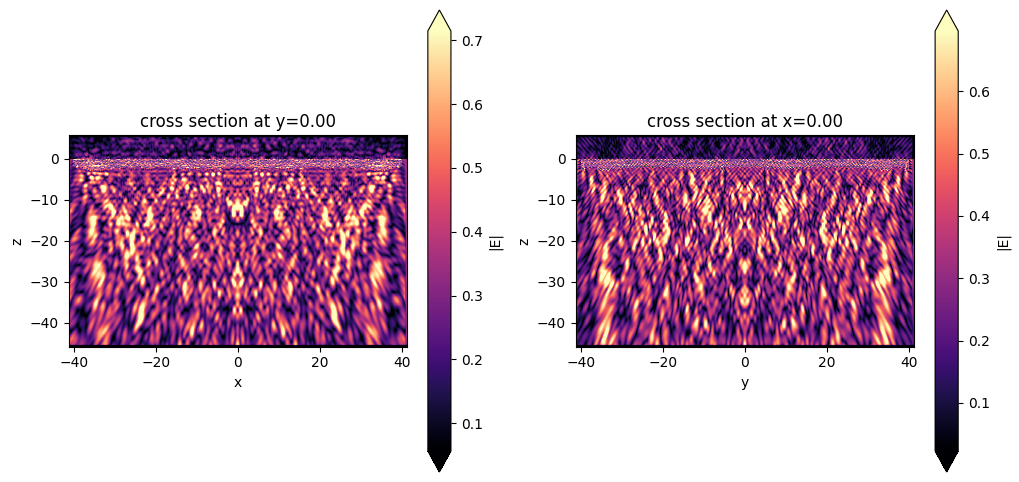

In [211]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

sim_data.plot_field(field_monitor_name='field_xz', field_name='E', val='abs', ax=ax1)
sim_data.plot_field(field_monitor_name='field_yz', field_name='E', val='abs', ax=ax2)
plt.show()

In [203]:
web.real_cost(job.task_id)

14:44:06 EEST Billed flex credit cost: 11.560.

              Note: the task cost pro-rated due to early shutoff was below the  
              minimum threshold, due to fast shutoff. Decreasing the simulation 
              'run_time' should decrease the estimated, and correspondingly the 
              billed cost of such tasks.

11.559960497137153

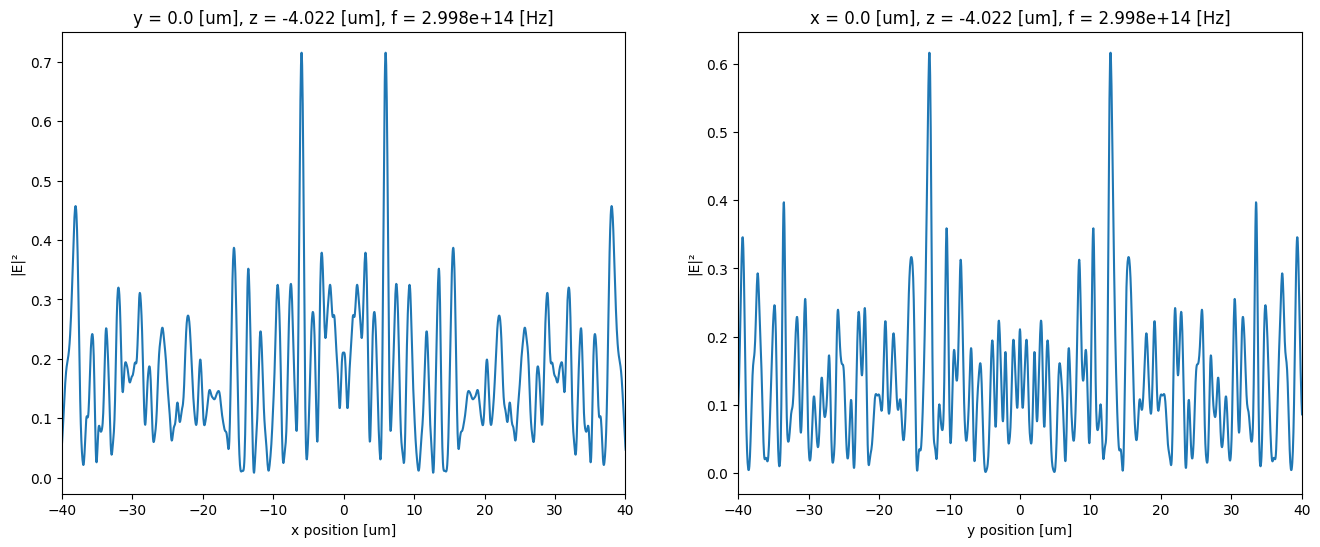

In [210]:
focal_z = -4 # z position of the focal spot

# plot field intensity at the focus
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

sim_data.get_intensity(field_monitor_name='field_xz').sel(y=0, z=focal_z, f=freq0, method='nearest').plot(ax=ax1)
ax1.set_xlim([-40,40])

sim_data.get_intensity(field_monitor_name='field_yz').sel(x=0, z=focal_z, f=freq0, method='nearest').plot(ax=ax2)
ax2.set_xlim([-40,40])
plt.show()


In [212]:
print(sim_data.log)

[11:39:00] INFO: Auto meshing using wavelength 1.0000 defined from sources.     
           USER: Simulation domain Nx, Ny, Nz: [2000, 2000, 803]                
           USER: Applied symmetries: (0, 0, 0)                                  
[11:39:01] USER: Number of computational grid points: 3.2264e+09.               
           USER: Subpixel averaging method: SubpixelSpec(attrs={},              
           dielectric=PolarizedAveraging(attrs={}, type='PolarizedAveraging'),  
           metal=Staircasing(attrs={}, type='Staircasing'),                     
           pec=PECConformal(attrs={}, type='PECConformal',                      
           timestep_reduction=0.3), type='SubpixelSpec')                        
           USER: Number of time steps: 1.3552e+04                               
           USER: Automatic shutoff factor: 1.00e-05                             
           USER: Time step (s): 7.3798e-17                                      
           USER:            

In [244]:
fxz_data = sim_data["field_yz"]

In [245]:
fxz_data.Ex.shape

(1, 2001, 804, 1)

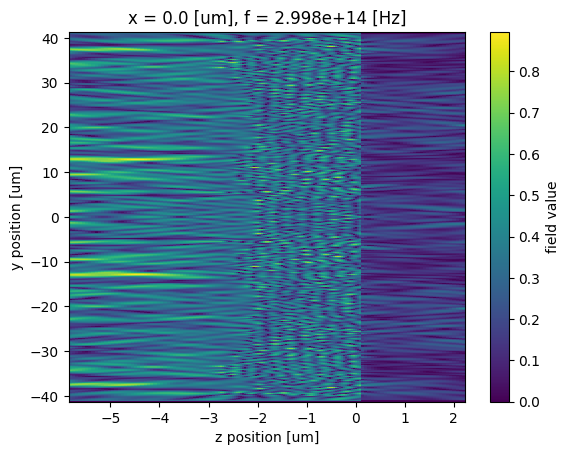

In [246]:
fxz_data.Ex[:, :, 600:750, 0].abs.plot()